In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch

from tqdm import tqdm

sys.path.insert(0, "../")

%load_ext autoreload
%autoreload 2

/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import src

In [3]:
from src.models.hmr import get_hmr
from src.functional.hmr import hmr_inference
def get_hmr_pretrained(ckpt_path):
    ### load hmrnet
    hmrnet = get_hmr(pretrained=True)
    ckpt = torch.load(ckpt_path, map_location="cpu")
    hmrnet.load_state_dict(ckpt["hmrnet_state_dict"])
    hmrnet.eval();
    return hmrnet

In [4]:
from src.datasets.datasets_common import UNNORMALIZE
from src.functional.smpl import get_smpl_model
from src.utils.vis_utils import render_mesh_onto_image_batch
from src.utils.vis_utils import make_square_grid

In [5]:
device = "cuda:0"
smpl_model = get_smpl_model().to(device)
smpl_model_faces = torch.tensor(smpl_model.faces.astype(int).copy()).unsqueeze(0)

## inference on 3DPW

In [109]:
from src.datasets.threedpw import ThreeDPW
seqlen = 5
threedpw_ds = ThreeDPW(set="train", seqlen=seqlen, debug=True, overlap=0., color_distort=False, use_OFformat=True, videoOF_format=1000)




3DPW Dataset overlap ratio:  0.0
Loaded 3dpw dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_processed/train/3dpw_train_db.pt
3dpw - number of dataset objects 4521


torch.Size([5, 1000, 1000, 3])
torch.Size([5, 1000, 1000, 3])


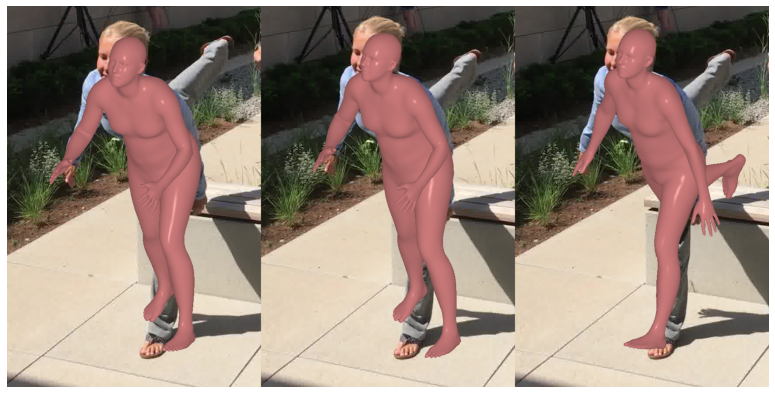

In [150]:
idx = 67
img = threedpw_ds[idx]['video']
imgHR = threedpw_ds[idx]['videoOF']



ckpt = "/cvlabdata2/home/davydov/videoHMR_SSL/output/train_hmr_fractional/train_hmr_frac__50/best.pth"
hmrnet = get_hmr_pretrained(ckpt).to(device)
with torch.no_grad():
    out = hmr_inference(img.to(device), hmrnet, smpl_model)

verts3d_bbox = out['verts3d']
verts3d_bbox = verts3d_bbox / 224 * threedpw_ds.videoOF_format

rendered_imgs = render_mesh_onto_image_batch(
        UNNORMALIZE(imgHR), 
        verts3d_bbox, 
        faces=smpl_model_faces.repeat(imgHR.size(0),1,1).to(device), 
        device=device)
print(rendered_imgs.shape)
delta = 200
rendered_imgs = rendered_imgs[...,delta:-delta,:]

delta = 50
rendered_imgs = rendered_imgs[...,delta:-delta,:,:]

###
final12 = rendered_imgs[:2]
###

ckpt = "/cvlabdata2/home/davydov/videoHMR_SSL/eft_model_zoo/2020_05_31-00_50_43-best-51.749683916568756_fixed.pt"
hmrnet = get_hmr_pretrained(ckpt).to(device)
with torch.no_grad():
    out = hmr_inference(img.to(device), hmrnet, smpl_model)

verts3d_bbox = out['verts3d']
verts3d_bbox = verts3d_bbox / 224 * threedpw_ds.videoOF_format
    
rendered_imgs = render_mesh_onto_image_batch(
        UNNORMALIZE(imgHR), 
        verts3d_bbox, 
        faces=smpl_model_faces.repeat(imgHR.size(0),1,1).to(device), 
        device=device)
print(rendered_imgs.shape)
delta = 200
rendered_imgs = rendered_imgs[...,delta:-delta,:]

delta = 50
rendered_imgs = rendered_imgs[...,delta:-delta,:,:]
final3 = rendered_imgs[1:2]



final_3dpw = torch.cat((final12, final3), dim=0)
final_3dpw = torch.cat(list(final_3dpw), dim=1)

fig, ax = plt.subplots(1,1,figsize=(3*7,7))
ax.imshow(final_3dpw)
ax.set_axis_off()

In [151]:
final_3dpw.shape

torch.Size([900, 1800, 3])

## inference on PennAction

In [137]:
from src.datasets.pennaction import PennAction
seqlen = 5
pennaction_ds = PennAction(seqlen=seqlen, use_OFformat=True, videoOF_format=1000)

Loaded pennaction dataset from /cvlabsrc1/cvlab/dataset_PennAction/Penn_Action/../pennaction_train_scale12_db.pt
pennaction - number of dataset objects 31824


torch.Size([3, 1000, 1000, 3])


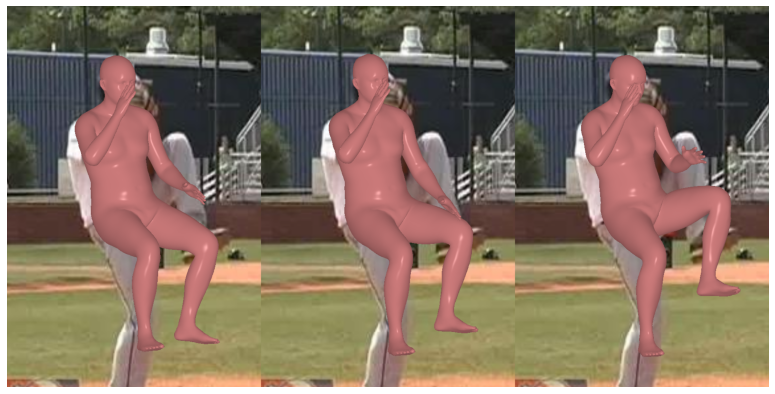

In [163]:
idx = 12
img = pennaction_ds[idx]['video']
imgHR = pennaction_ds[idx]['videoOF']

for ckpt in [
    "/cvlabdata2/home/davydov/videoHMR_SSL/output/train_hmr_fractional/train_hmr_frac__50/best.pth",
#     "/cvlabdata2/home/davydov/videoHMR_SSL/eft_model_zoo/2020_05_31-00_50_43-best-51.749683916568756_fixed.pt",
    ]:
    hmrnet = get_hmr_pretrained(ckpt).to(device)


    with torch.no_grad():
        out = hmr_inference(img.to(device), hmrnet, smpl_model)

    verts3d_bbox = out['verts3d']
    verts3d_bbox = verts3d_bbox / 224 * pennaction_ds.videoOF_format

    
imgHR = torch.cat((imgHR[:2], imgHR[1:2]), dim=0)
verts3d_bbox = torch.cat((verts3d_bbox[:2], verts3d_bbox[2:3]), dim=0)

rendered_imgs = render_mesh_onto_image_batch(
        UNNORMALIZE(imgHR), 
        verts3d_bbox, 
        faces=smpl_model_faces.repeat(imgHR.size(0),1,1).to(device), 
        device=device)

print(rendered_imgs.shape)
delta = 200
rendered_imgs = rendered_imgs[...,delta:-delta,:]

delta = 50
final_pa = rendered_imgs[...,delta:-delta,:,:]
final_pa = torch.cat(list(final_pa), dim=1)

fig, ax = plt.subplots(1,1,figsize=(seqlen*7,7))
ax.imshow(final_pa)
ax.set_axis_off()

In [164]:
final_pa.shape

torch.Size([900, 1800, 3])

## inference on H36M

In [135]:
from src.datasets.h36m import Human36M
seqlen = 5
h36m_ds = Human36M(seqlen=seqlen, set="train", debug=True, overlap=0., use_OFformat=True, videoOF_format=1000)

Human36M Dataset overlap ratio:  0.0
Loaded h36m dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/h36m/h36m_train_25fps_db.pt
h36m - number of dataset objects 58657


torch.Size([5, 1000, 1000, 3])
torch.Size([5, 1000, 1000, 3])
torch.Size([2, 900, 600, 3]) torch.Size([1, 900, 600, 3])


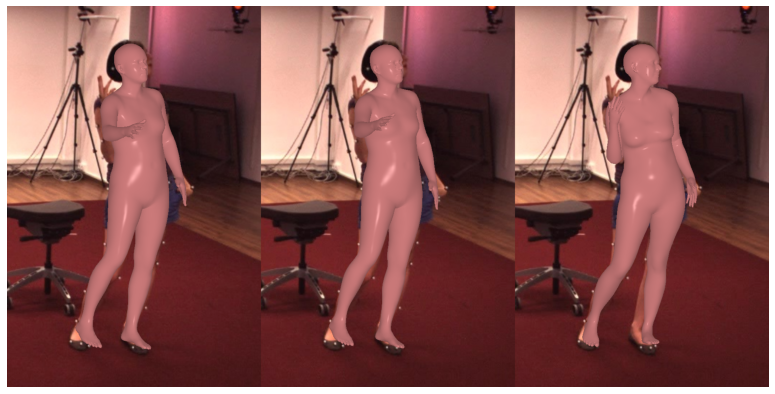

In [161]:
idx = 150
img = h36m_ds[idx]['video']
imgHR = h36m_ds[idx]['videoOF']


ckpt = "/cvlabdata2/home/davydov/videoHMR_SSL/output/train_hmr_fractional/train_hmr_frac__50/best.pth"
hmrnet = get_hmr_pretrained(ckpt).to(device)
with torch.no_grad():
    out = hmr_inference(img.to(device), hmrnet, smpl_model)

verts3d_bbox = out['verts3d']
verts3d_bbox = verts3d_bbox / 224 * h36m_ds.videoOF_format
rendered_imgs = render_mesh_onto_image_batch(
        UNNORMALIZE(imgHR), 
        verts3d_bbox, 
        faces=smpl_model_faces.repeat(imgHR.size(0),1,1).to(device), 
        device=device)
print(rendered_imgs.shape)
delta = 200
rendered_imgs = rendered_imgs[...,delta:-delta,:]

delta = 50
rendered_imgs = rendered_imgs[...,delta:-delta,:,:]
# rendered_imgs = torch.cat(list(rendered_imgs), dim=1)

final12 = rendered_imgs[1:3]


ckpt = "/cvlabdata2/home/davydov/videoHMR_SSL/eft_model_zoo/2020_05_31-00_50_43-best-51.749683916568756_fixed.pt"
hmrnet = get_hmr_pretrained(ckpt).to(device)
with torch.no_grad():
    out = hmr_inference(img.to(device), hmrnet, smpl_model)
verts3d_bbox = out['verts3d']
verts3d_bbox = verts3d_bbox / 224 * h36m_ds.videoOF_format
rendered_imgs = render_mesh_onto_image_batch(
        UNNORMALIZE(imgHR), 
        verts3d_bbox, 
        faces=smpl_model_faces.repeat(imgHR.size(0),1,1).to(device), 
        device=device)
print(rendered_imgs.shape)
delta = 200
rendered_imgs = rendered_imgs[...,delta:-delta,:]

delta = 50
rendered_imgs = rendered_imgs[...,delta:-delta,:,:]
# rendered_imgs = torch.cat(list(rendered_imgs), dim=1)
    
final3 = rendered_imgs[2:3]

print(final12.shape, final3.shape)
final_h36m = torch.cat((final12, final3), dim=0)
final_h36m = torch.cat(list(final_h36m), dim=1)

fig, ax = plt.subplots(1,1,figsize=(3*7,7))
ax.imshow(final_h36m)
ax.set_axis_off()

In [165]:
final_h36m.shape

torch.Size([900, 1800, 3])

torch.Size([2700, 1800, 3]) 1.5


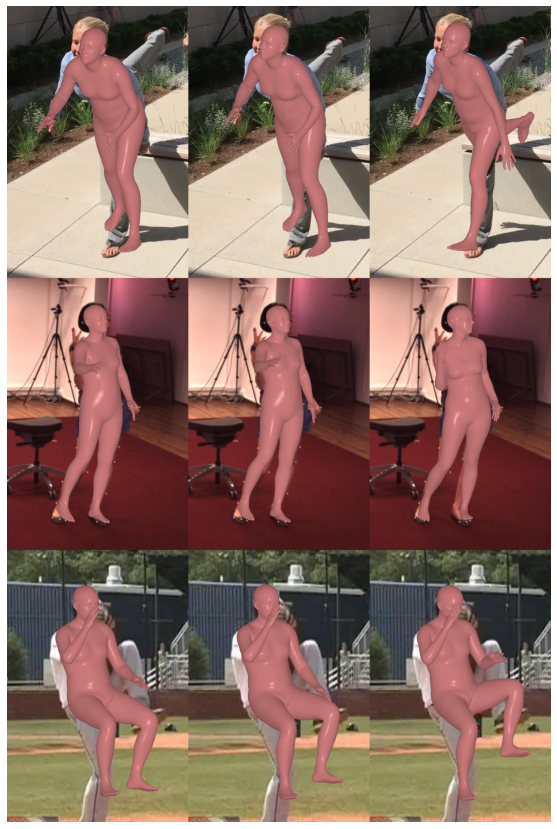

In [171]:
final_fig = torch.cat((final_3dpw, final_h36m, final_pa), dim=0)
print(final_fig.shape, final_fig.shape[0] / final_fig.shape[1])

fig, ax = plt.subplots(1,1,figsize=(10, 15))
ax.imshow(final_fig)
ax.set_axis_off()

fig.savefig("./../paper_sub/missed_alignment.pdf", format="pdf", bbox_inches="tight")